In [ ]:
import numpy as np

import tensorflow as tf
import tensorflow_hub as hub

import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras.utils import plot_model
from sklearn.model_selection import train_test_split

import string
import pandas as pd
import time
%matplotlib inline


def plot_history(hist,name="tmp"):
  data_length = hist["loss"].shape[0]
  points = np.arange(0,data_length)
  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.semilogy(points, hist['loss'][points],"o-",
           label='Train Loss')
  plt.semilogy(points, hist['val_loss'][points],'^--',
           label = 'Test Loss')
  plt.legend()
  plt.show()
  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Accuracy')
  plt.semilogy(points, hist['accuracy'][points],"o-",
           label='Train Accuracy')
  plt.semilogy(points, hist['val_accuracy'][points],'^--',
           label = 'Test Accuracy')
  plt.legend()
  plt.show()

In [ ]:
"""imdb = keras.datasets.imdb
(train_data, train_labels), (test_data, test_labels) = imdb.load_data(num_words=10000, skip_top=0)

print(train_labels)"""

'imdb = keras.datasets.imdb\n(train_data, train_labels), (test_data, test_labels) = imdb.load_data(num_words=10000, skip_top=0)\n\nprint(train_labels)'

In [ ]:
def encode_review(text):
  tmp = np.zeros(31,dtype="int")
  tmp[0] = 1 #start character
  #remove punctuation
  text = text.translate(str.maketrans('', '', string.punctuation))
  words = text.lower().split() #make string lower case and split at spaces
  for i in range(np.min((len(words),30))):
    tmp_index = 2
    try:
      tmp_index = np.min((49999,word_index[words[i]]))
    except:
      #do nothing
      0==0
    tmp[i+1] = tmp_index
  return tmp

def decode_review(text):
    return ' '.join([reverse_word_index.get(i, '?') for i in text])

In [ ]:
#Putting data into dataframe and splitting into test and training data
df = pd.read_csv('pickupdata_final.csv', #Change file name for actual file name
                 sep=',',
                 names=['Pickup Lines', 'Ratings'])
print(df.head)

for i, line in enumerate(df['Pickup Lines']):
  df.at[i, 'Pickup Lines'] = encode_review(line)

pickup_lines = df['Pickup Lines']
ratings = df['Ratings']

train_pickup, test_pickup, train_ratings, test_ratings = train_test_split(pickup_lines, ratings,
                                   random_state=104,
                                   test_size=0.3,
                                   shuffle=True)

train_pickup_lst = train_pickup.values.tolist()
test_pickup_lst = test_pickup.values.tolist()

<bound method NDFrame.head of                                            Pickup Lines  Ratings
0     Are you a pair of glasses? You don’t appear to...      1.0
1             Want to play agent and fondle my package?      1.0
2     God has used you to teach me what true love re...      0.0
3     My body is a temple, so make sure you take you...      1.0
4     You must be Egyptian because I'm a slave for you.      1.0
...                                                 ...      ...
2034  Girl, are you trash? Because I am into some di...      NaN
2035  If loving you is a heresy, then let me be anat...      NaN
2036  The Flying Spaghetti Monster has a plan for us...      NaN
2037             Did I see you in line for the Passion?      NaN
2038  I’m a drummer, and I can teach you. I could ev...      NaN

[2039 rows x 2 columns]>


In [ ]:
#Downloaded the dictionary of the imdb dataset so that we can also turn our words into numbers as well
imdb = keras.datasets.imdb
# A dictionary mapping words to an integer index
word_index = imdb.get_word_index()

# The first indices are reserved
word_index = {k:(v+3) for k,v in word_index.items()}
word_index["<PAD>"] = 0
word_index["<START>"] = 1
word_index["<UNK>"] = 2  # unknown
word_index["<UNUSED>"] = 3

reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])
reverse_word_index[0] = ""

In [ ]:
train_data_pickup = keras.preprocessing.sequence.pad_sequences(train_pickup_lst,
                                                        value=word_index["<PAD>"],
                                                        padding='post',
                                                        maxlen=31)

test_data_pickup = keras.preprocessing.sequence.pad_sequences(test_pickup_lst,
                                                       value=word_index["<PAD>"],
                                                       padding='post',
                                                       maxlen=31)

In [ ]:
vocab_size = 50000

model = keras.Sequential()
model.add(keras.layers.Embedding(vocab_size, 16))
model.add(tf.keras.layers.Dropout(0.4))
model.add(keras.layers.GlobalAveragePooling1D())
model.add(keras.layers.Dense(16, activation=tf.nn.leaky_relu,kernel_regularizer=keras.regularizers.l2(0.001)))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Dropout(0.1))
model.add(keras.layers.Dense(4, activation=tf.nn.leaky_relu,kernel_regularizer=keras.regularizers.l2(0.001)))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Dropout(0.1))
model.add(keras.layers.Dense(4, activation=tf.nn.leaky_relu,kernel_regularizer=keras.regularizers.l2(0.001)))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Dropout(0.1))
model.add(keras.layers.Dense(1, activation=tf.nn.sigmoid))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 16)          800000    
                                                                 
 dropout (Dropout)           (None, None, 16)          0         
                                                                 
 global_average_pooling1d (G  (None, 16)               0         
 lobalAveragePooling1D)                                          
                                                                 
 dense (Dense)               (None, 16)                272       
                                                                 
 batch_normalization (BatchN  (None, 16)               64        
 ormalization)                                                   
                                                                 
 dropout_1 (Dropout)         (None, 16)                0

In [ ]:
checkpoint_path = 'bessel.weights.best.hdf5'
checkpointer = keras.callbacks.ModelCheckpoint(filepath=checkpoint_path, verbose = 0, save_best_only=True)

"""model.compile(loss='binary_crossentropy',
             optimizer='adam',
             metrics=['accuracy'])"""

"model.compile(loss='binary_crossentropy',\n             optimizer='adam',\n             metrics=['accuracy'])"

In [ ]:
from keras.optimizers import SGD
opt = SGD(learning_rate=0.0001)
model.compile(loss = "binary_crossentropy", optimizer = opt, metrics=['accuracy'])

In [ ]:
def change_int (lst):
  for index, i in enumerate(lst):
    try:
      lst[index] = int(i)
    except:
      lst[index] = 0
  return lst

In [ ]:
train_ratings_lst = train_ratings.values.tolist()
train_ratings_lst = change_int(train_ratings_lst)

test_ratings_lst = test_ratings.values.tolist()
test_ratings_lst = change_int(test_ratings_lst)


train_ratings = np.array(train_ratings_lst)
train_pickup = np.array(train_pickup_lst)
test_ratings = np.array(test_ratings_lst)
test_pickup = np.array(test_pickup_lst)

In [ ]:
from numpy.matrixlib import test


epochs=100
history = model.fit(train_pickup, train_ratings,
                    validation_data=(test_pickup, test_ratings),
                    epochs=epochs,
                    callbacks=[checkpointer]
                    )

# convert the history.history dict to a pandas DataFrame:
hist_df = pd.DataFrame(history.history)

# save to json:
hist_csv_file = 'history_pickup.csv'
with open(hist_csv_file, mode='w') as f:
    hist_df.to_csv(f)

Epoch 1/100
45/45 [==============================] - 6s 48ms/step - loss: 0.9145 - accuracy: 0.4919 - val_loss: 0.7368 - val_accuracy: 0.3072
Epoch 2/100
45/45 [==============================] - 1s 11ms/step - loss: 0.9029 - accuracy: 0.4723 - val_loss: 0.7510 - val_accuracy: 0.3072
Epoch 3/100
45/45 [==============================] - 1s 18ms/step - loss: 0.8769 - accuracy: 0.4898 - val_loss: 0.7634 - val_accuracy: 0.3072
Epoch 4/100
45/45 [==============================] - 0s 10ms/step - loss: 0.8480 - accuracy: 0.4814 - val_loss: 0.7744 - val_accuracy: 0.3072
Epoch 5/100
45/45 [==============================] - 0s 11ms/step - loss: 0.8427 - accuracy: 0.4919 - val_loss: 0.7879 - val_accuracy: 0.3072
Epoch 6/100
45/45 [==============================] - 0s 7ms/step - loss: 0.8346 - accuracy: 0.5053 - val_loss: 0.8088 - val_accuracy: 0.3072
Epoch 7/100
45/45 [==============================] - 0s 7ms/step - loss: 0.8206 - accuracy: 0.4982 - val_loss: 0.8218 - val_accuracy: 0.3072
Epoch 8/

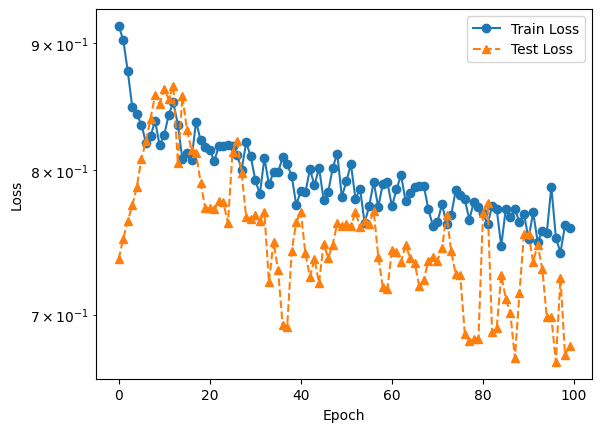

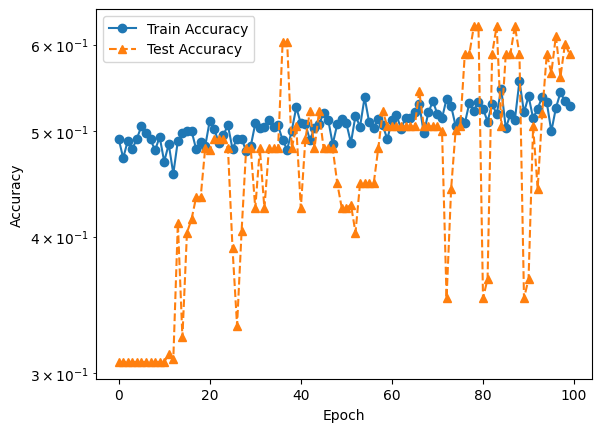

In [ ]:
model.load_weights(checkpoint_path)
with open('history_pickup.csv', "rb") as file_pi:
    history_load = pd.read_csv(file_pi)
plot_history(history_load)
plt.show()

In [ ]:
#find which words are most alike amongst the top 1000 words
embedding_model = tf.keras.models.Model(inputs=model.input, outputs=model.layers[0].output)
word_ints = np.arange(0,1000).reshape(1,1000)
word_embeds = np.array(embedding_model(word_ints)).reshape(1000,16)
most_alike = np.zeros(1000,dtype="int")
for i in range(1000):
  val = 1e14
  for j in range(1000):
    if (i != j):
      tmp = np.linalg.norm(word_embeds[i]-word_embeds[j])
      if (tmp < val):
        most_alike[i] = j
        val = tmp

In [ ]:
for i in range(300,350):
  print(decode_review([i,most_alike[i]]))

1 shame
said within
effects of
later unfortunately
takes version
instead whose
seem predictable
beautiful there
john rate
himself also
version takes
audience writer
high dog
house home
night you're
during final
everyone use
left person
special let
seeing off
half case
excellent new
wife fall
star zombie
shot our
war along
idea tell
nice true
black local
less piece
mind crazy
simply yet
read female
second development
else hilarious
you're night
father certainly
fan direction
poor none
help age
completely took
death save
3 job
used while
home superb
either crazy
short set
line ten
given in
men review


In [ ]:
tmp_input = np.zeros((1,31), dtype="int") + 119
tmp_input[0,:] = encode_review("Sit on my face and I'll guess your weight")
print(tmp_input)
prediction = model.predict(tmp_input)

print("Rizz Probability: " + str(np.round(float(prediction[0])*100,1)) + "%")

[[   1  870   23   61  393    5 1815  482  129 3324    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0]]
1/1 [==============================] - 0s 38ms/step
Rizz Probability: 51.8%
